In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

from keras import backend as K
from keras.applications import VGG16
from keras.models import Model, load_model, Sequential
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.preprocessing import image
from keras.utils import plot_model, to_categorical

import numpy as np
import pandas as pd
from scipy.misc import imresize

import re
import shutil
import datetime
from pathlib import Path

import h5py

from IPython import display

from matplotlib import pyplot as plt
from plotly import plotly as py
from plotly import offline as pyo
from plotly import graph_objs as go

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using Te

# Transfer Learning Example: *notMNIST* dataset
This Jupyter Notebook demonstrates a Machine Learning pipeline for utilizing a pre-trained model for an image classification problem via transfer learning. 

Due to the large size of the pre-trained model used (VGG-16), this model was trained on an AWS EC2 p2.xlarge instance. 

## Exploratory Data Analysis

The *notMNIST* dataset consists of the English letters 'A' to 'J' (10 letters in total) in various fonts. 

Let's visualise the *notMNIST* dataset. Below are subset of images from the aforementioned dataset.

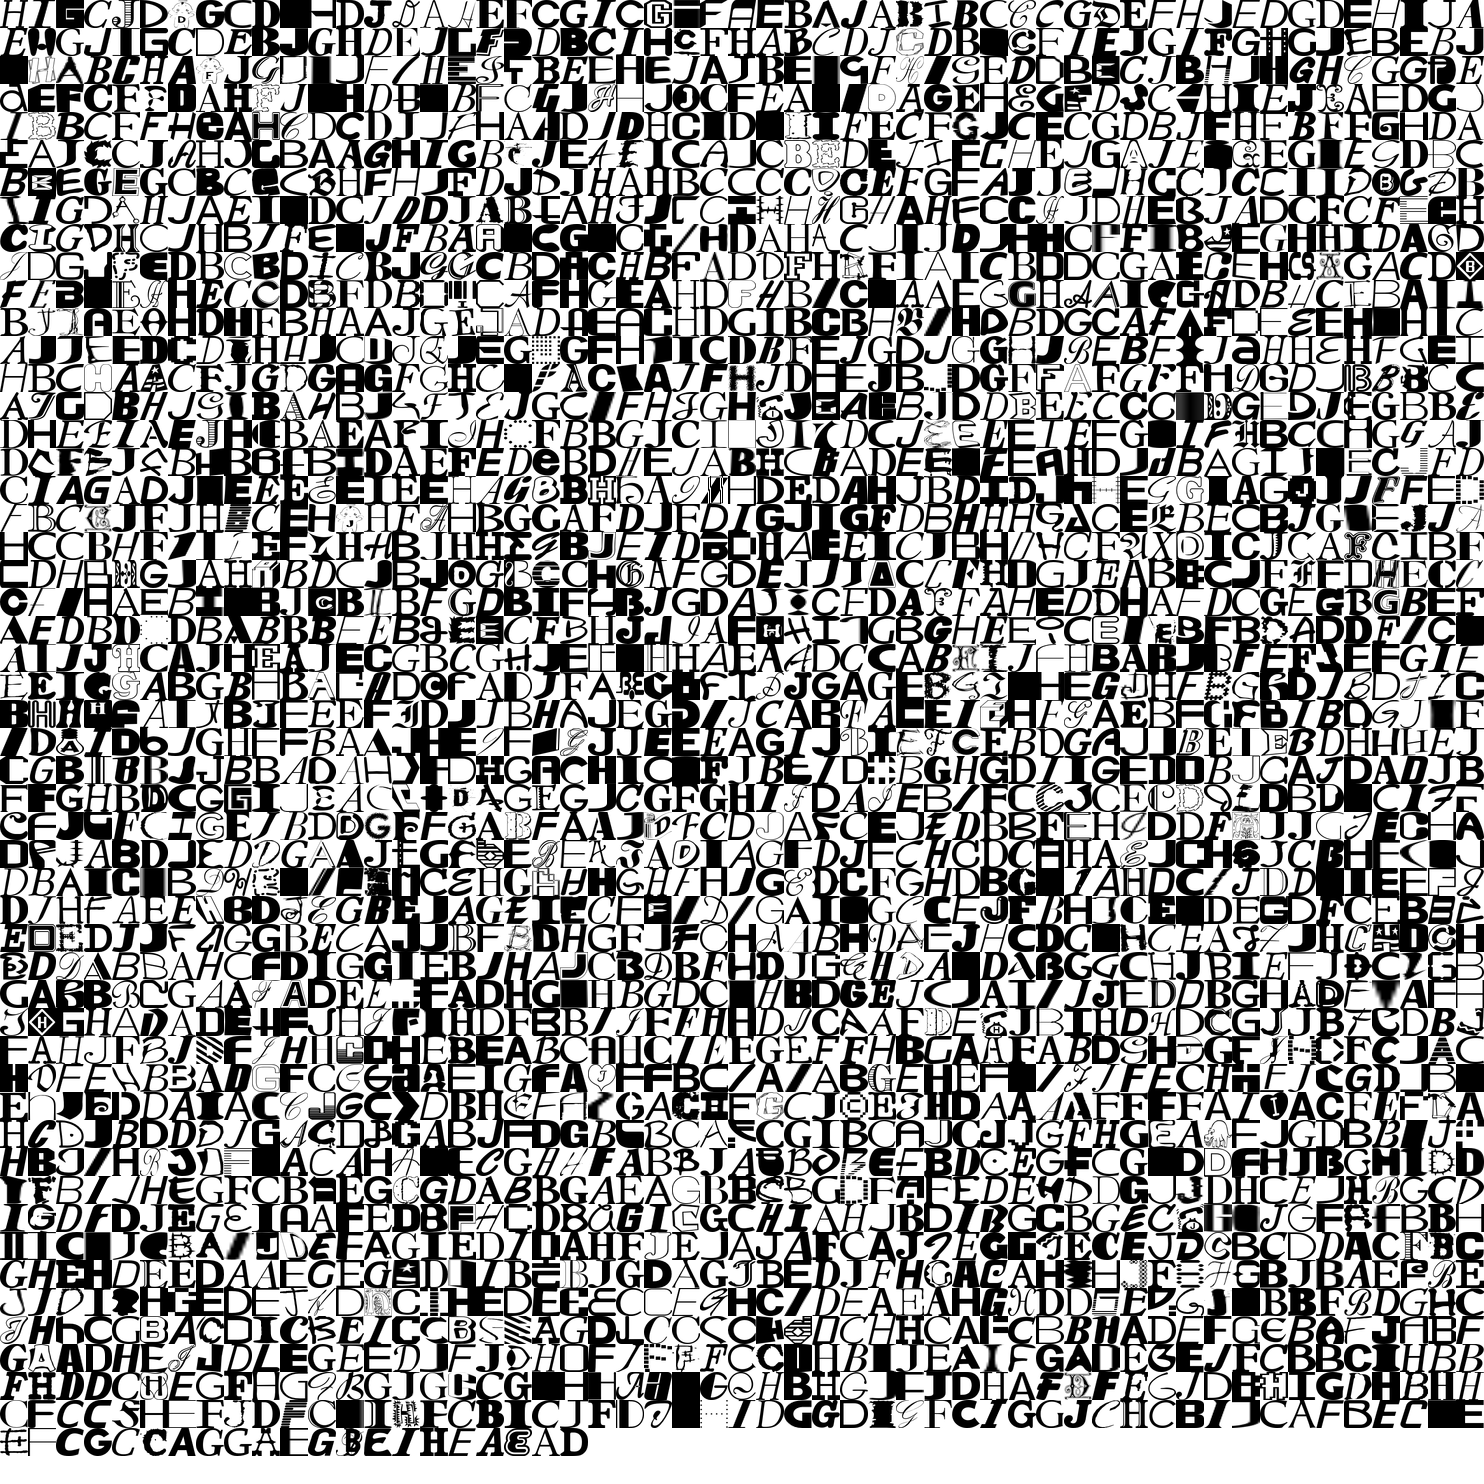

In [3]:
display.Image(filename='/home/ubuntu/SharpestMinds/Data/sprite.png')

We begin by loading the "images" and "labels" from `notMNIST.npz` into `X` and `Y` respectively. Each input image contains 28-by-28 pixels.

Since most pretrained CNNs require a larger input image size and three colour channels (RGB), each image is padded with zeros to be 200-by-200 pixels before being stacked with three of its identical copies to form the three channels required by the pretrained CNN.

In [4]:
# Load data 
data = np.load('Data/notMNIST.npz')

# Extract input and labels
X = [np.pad(x, 86, 'constant', constant_values=(0)) for x in data['images']]
X = np.stack([X, X, X], axis=-1) / 255  # normalise values to be between 0 and 1
Y = to_categorical(data['labels'])  # convert labels to one-hot encodings

We can visualise how a padded input image will look:

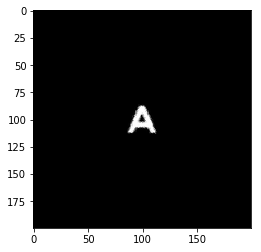

In [5]:
plt.imshow(X[0], cmap='gray')

Below, we observe that there are equal numbers examples for each label category. This makes training easier as the model will not be biased to preferentially learn one category over another.

If there were drastic size differences between categories, we would have to create a custom Keras loss function that penalises errors made on categories with fewer examples. 

In [6]:
# pd.DataFrame(data['labels'], columns=['labels']).groupby('labels').agg({'labels': 'count'})
pd.DataFrame(np.array(data['labels']), columns=['labels']).groupby('labels').agg({'labels': 'count'})

labels
labels        
0         1872
1         1873
2         1873
3         1873
4         1873
5         1872
6         1872
7         1872
8         1872
9         1872

## Transfer Learning Pipeline
Transfer learning involves repurposing a pre-trained model for a more custom purpose. The top layers of an existing model (which we shall subsequently refer to as the **Base Model**) are replaced with `Dense` (Fully-Connected) and `Softmax` layers (
**Top Model**). The output dimensions of the `Softmax` layer is equal to the number of categories we are trying to classify. 

First, the randomly-initialised weights of the top model are trained.

The next step is the fine-tuning phase. Here, the weights of layers higher in the Base Model may be included for fine-tuning along with the weights of the top layer, depending on the nature / distribution of data for our custom use case.

As a rule of thumb, the more data we have, the more layers of the Base Model whose weights can be fine-tuned.

## Pre-trained VGG16 as base model
For our base mode, we will use a pre-trained VGG16. 

N.B. This model may be overkill for classifying *notMNIST* characters, but this pipeline can be easily repurposed for more complex computer vision problems provided by SharpestMinds clients.

In [9]:
# Clear session of any existing graphs
K.clear_session()

# Create base model on a GPU
# Note: multi_gpu_model cannot be called as that requires more than one GPU
with tf.device('/gpu:0'):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=X[0].shape)

## Top Model Training
### Save bottleneck encodings
To speed up the training of the Top Model, the activations / encodings of each input image only has to run once through the Base Model since we are not updating any the weights of the Base Model.

As such, the encodings can be saved and from that point, we can train our Top Model to map these encodings to their true labels. 

In [52]:
X_encodings = base_model.predict(X, verbose=1)

18724/18724 [==============================] - 176s 9ms/step


In [53]:
ENCODINGS_DIR = 'Data/notMNIST_enc_VGG.npz'
np.savez(ENCODINGS_DIR, X_enc=X_encodings, Y=Y)

### Load and partition encodings
We load the saved encodings and partition them into training, validation and test datasets. 

In [2]:
def shuffle_and_split(data, target, split_ratio=[.8, .1, .1], shuffle=True):
    '''
    Split `data` and `target` according to `split_ratio`.
    
    Returns training, dev and test sets. 
    '''
    # Ensure data and target are of the same length
    assert len(data) == len(target)
    
    # Ensure split_ratio sums to 1
    assert sum(split_ratio) == 1.
    
    # Define num of datapoints
    N = len(data)
    
    # Create a sampling index
    index = np.arange(N)
    if shuffle:
        np.random.shuffle(index)
    
    # Split input data
    X_train, X_dev, X_test = np.split(data[index], (np.cumsum(split_ratio) * N).astype(int)[:-1])
    
    # Split target labels
    Y_train, Y_dev, Y_test = np.split(target[index], (np.cumsum(split_ratio) * N).astype(int)[:-1])
    
    return X_train, Y_train, X_dev, Y_dev, X_test, Y_test

In [10]:
data_enc = np.load(ENCODINGS_DIR)
X_enc = data_enc['X_enc']
Y = data_enc['Y']

In [11]:
# Segment dataset
X_train_enc, Y_train, X_dev_enc, Y_dev, X_test_enc, Y_test = shuffle_and_split(X_enc, Y)

print('Number of training examples: ', len(X_train_enc))
print('Number of validation examples: ', len(X_dev_enc))
print('Number of test examples: ', len(X_test_enc))
print('Shape of inputs: ', X_train_enc[0].shape)
print('Shape of target labels: ', Y_train[0].shape)

Number of training examples:  14979
Number of validation examples:  1872
Number of test examples:  1873
Shape of inputs:  (6, 6, 512)
Shape of target labels:  (10,)


### Create and train Top Model
Here, we create a Top Model which consists of:
* A Flatten layer
* A Dense layer with 256 hidden units and ReLU activation
* A Batch Normalisation layer
* A Softmax layer wiht 10 output categories

In [36]:
def create_top_model(input_shape, num_classes, num_dense_hidden_units, lambda_):
    '''
    A decorator that returns a function to create the Top Model.
    
    Inputs:
        input_shape:            Input shape
        num_classes:            Number of classes in output
        num_dense_hidden_units: Number of hidden units in the Dense layer
        lambda_:                L2 regularization parameter
    
    Returns:
        Function that creates Top Model
    '''
    def _create_top_model(combine_with_base=False, base_model=None):
        '''
        Create Top Model, either by creating a standalone model or by 
        building on top of Base Model.
        
        Inputs:
            combine_with_base: Boolean on whether to build Top Model
                               on top of Base Model
            base_model:        Base Model that must be specified if
                               `combine_with_base` is True.
                               
        Returns:
            A Top Model.
        '''
        # Create a standalone Top Model or by building on Base Model
        if combine_with_base:
            assert base_model != None, 'base_model not provided.'
            X_input = base_model.output
        else:
            X_input = Input(input_shape)
            
        # Add additional layers
        X = Flatten(name='TOP_FLATTEN')(X_input)
        X = Dense(num_dense_hidden_units, activation='relu', kernel_regularizer=l2(lambda_), name='TOP_DENSE')(X)
        X = BatchNormalization(name='TOP_BATCH_NORM')(X)
        X = Dense(num_classes, activation='softmax', kernel_regularizer=l2(lambda_), name='TOP_SOFTMAX')(X)

        # Create model
        model = Model(base_model.input if combine_with_base else X_input, X)

        return model
    return _create_top_model_fnal

In [23]:
# Define function which generates top model
top_model_function = create_top_model(base_model.output_shape[1:], num_classes=Y[0].size, 
                                      num_dense_hidden_units=256, lambda_=1e-1)

Here, the model is built and compiled.

We use an Adam optimizer to minimise the categorical crossentropy (as we are performing multi-class classification). At the same time, we keep track of the accuracy by defining it in `metrics`. 

In [37]:
# Build and compile model
top_model = top_model_function()

In [ ]:
top_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Before beginning training, the following callbacks are created and attached to the model.

* `ModelCheckpoint`: Saves a copy of the model and its weights. To be prudent on storage, only the best model (determined by validation accuracy) is saved.
* `TensorBoard`: Enabled to visualise performance metrics and `tf.graph`

In [14]:
checkpoint_path = Path('Checkpoints/{}'.format(datetime.date.today()))
checkpoint_path.mkdir(exist_ok=True, parents=True)

callbacks = [
    ModelCheckpoint(str(checkpoint_path / 'VGG_top.h5'), 
                    save_best_only=True, save_weights_only=False),
    TensorBoard('Logs/{}/VGG_top'.format(datetime.date.today()))
]

The Top Model is now trained on 200 epochs.

In [129]:
top_model.fit(X_train_enc, Y_train, validation_data=(X_dev_enc, Y_dev), 
              epochs=200, batch_size=32, callbacks=callbacks)

Train on 14979 samples, validate on 1872 samples
Epoch 1/200
14979/14979 [==============================] - 8s 534us/step - loss: 2.2350 - acc: 0.8389 - val_loss: 10.3914 - val_acc: 0.1020
Epoch 2/200
14979/14979 [==============================] - 9s 580us/step - loss: 1.0873 - acc: 0.8479 - val_loss: 6.4777 - val_acc: 0.1106
Epoch 3/200
14979/14979 [==============================] - 6s 417us/step - loss: 1.0709 - acc: 0.8528 - val_loss: 12.0811 - val_acc: 0.1031
Epoch 4/200
14979/14979 [==============================] - 6s 418us/step - loss: 1.0612 - acc: 0.8547 - val_loss: 9.0788 - val_acc: 0.2687
Epoch 5/200
14979/14979 [==============================] - 6s 418us/step - loss: 0.9910 - acc: 0.8597 - val_loss: 12.1424 - val_acc: 0.1052
Epoch 6/200
14979/14979 [==============================] - 6s 420us/step - loss: 1.0317 - acc: 0.8554 - val_loss: 11.5186 - val_acc: 0.1741
Epoch 7/200
14979/14979 [==============================] - 6s 419us/step - loss: 0.9661 - acc: 0.8596 - val_loss:

14979/14979 [==============================] - 6s 416us/step - loss: 0.6875 - acc: 0.8777 - val_loss: 6.3397 - val_acc: 0.3958
Epoch 60/200
14979/14979 [==============================] - 8s 553us/step - loss: 0.6785 - acc: 0.8731 - val_loss: 2.9662 - val_acc: 0.4322
Epoch 61/200
14979/14979 [==============================] - 6s 417us/step - loss: 0.7377 - acc: 0.8698 - val_loss: 9.6788 - val_acc: 0.1373
Epoch 62/200
14979/14979 [==============================] - 6s 418us/step - loss: 0.7200 - acc: 0.8721 - val_loss: 13.9038 - val_acc: 0.1106
Epoch 63/200
14979/14979 [==============================] - 6s 416us/step - loss: 0.7546 - acc: 0.8682 - val_loss: 11.8353 - val_acc: 0.2078
Epoch 64/200
14979/14979 [==============================] - 6s 417us/step - loss: 0.7734 - acc: 0.8661 - val_loss: 12.4742 - val_acc: 0.0983
Epoch 65/200
14979/14979 [==============================] - 6s 416us/step - loss: 0.7345 - acc: 0.8693 - val_loss: 9.0250 - val_acc: 0.2249
Epoch 66/200
14979/14979 [====

14979/14979 [==============================] - 6s 416us/step - loss: 0.6300 - acc: 0.8780 - val_loss: 5.3684 - val_acc: 0.2644
Epoch 176/200
14979/14979 [==============================] - 6s 419us/step - loss: 0.6435 - acc: 0.8766 - val_loss: 10.9033 - val_acc: 0.1122
Epoch 177/200
14979/14979 [==============================] - 6s 417us/step - loss: 0.6602 - acc: 0.8724 - val_loss: 7.1458 - val_acc: 0.1982
Epoch 178/200
14979/14979 [==============================] - 6s 419us/step - loss: 0.6698 - acc: 0.8746 - val_loss: 13.2392 - val_acc: 0.1368
Epoch 179/200
14979/14979 [==============================] - 6s 419us/step - loss: 0.6755 - acc: 0.8740 - val_loss: 10.1225 - val_acc: 0.1928
Epoch 180/200
14979/14979 [==============================] - 6s 418us/step - loss: 0.6749 - acc: 0.8728 - val_loss: 4.3992 - val_acc: 0.3419
Epoch 181/200
14979/14979 [==============================] - 6s 418us/step - loss: 0.7360 - acc: 0.8638 - val_loss: 12.8673 - val_acc: 0.0983
Epoch 182/200
14979/149

The latest model upon training completion may not be the best model (as it may have overfitted to the trainig set). As such, the best model (as defined by validation accuracy), is loaded from the 'Checkpoints' folder.

In [15]:
top_model = load_model(str(checkpoint_path / 'VGG_top.h5'))

Once we are satisfied with the trained Top Model, its weights are saved. 

In [17]:
top_model.save_weights('Checkpoints/2018-02-02/VGG_top_weights.h5')

## Data Augmentation
Data augmentation is a form of regularization to allow the Model to be more robust and generalise to more (noisier) inputs. We will utilise this in training the combined Model.

First, the padded input images are segmented into training, validation and test datasets. 

In [19]:
# Segment dataset
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = shuffle_and_split(X, Y)

print('Number of training examples: ', len(X_train))
print('Number of validation examples: ', len(X_dev))
print('Number of test examples: ', len(X_test))
print('Shape of inputs: ', X_train[0].shape)
print('Shape of target labels: ', Y_train[0].shape)

Number of training examples:  14979
Number of validation examples:  1872
Number of test examples:  1873
Shape of inputs:  (200, 200, 3)
Shape of target labels:  (10,)


Data Generators are created for each of these datasets. For the training set, the generator may apply various "noises" to the image including:
* rotation
* vertical and horizontal translations
* shear
* zoom

No noise is applied to the validation and test data generators.

In [31]:
# Train data generator
train_datagen = image.ImageDataGenerator(rotation_range = 40, 
                                         width_shift_range = 0.2, 
                                         height_shift_range = 0.2, 
                                         shear_range = 0.2,
                                         zoom_range = 0.2, 
                                         horizontal_flip = False,
                                         rescale = None)

# Dev (validation) and test data generator
dev_datagen = image.ImageDataGenerator(rescale = None)
test_datagen = image.ImageDataGenerator(rescale = None)

Next, we apply these parameterized data generators to our data.

In [32]:
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
dev_generator = dev_datagen.flow(X_dev, Y_dev, batch_size=32)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=32)

## Integrating Base Model and Top Model

In [18]:
def combined_model(base_model, top_model_fn, top_weights_dir, trainable_from=0):
    '''
    Combine base model with new functional instance of top model. Trained weights of Top Model
    are integrated into this combined model. Also, trainable attribute of layers starting from 
    index `trainable_from` are set to be True for fine-tuning.
    
    Inputs:
        base_model:      Pre-trained Keras CNN model
        top_model_fn:    Top Model generation function that creates a Top Model
                         standalone or built on top of Base Model.
        top_weights_dir: Directory where the top weights are saved
        trainable_from:  Minimum layer of Base Model whose weights are trainable
        
    Returns:
        A combined Keras model.
    '''
    # Load weights into an instance of top model
    top_model = top_model_fn(combine_with_base=False)
    top_model.load_weights(top_weights_dir)
    
    # Create a new instance of top model on the base model
    combined_model = top_model_fn(combine_with_base=True, base_model=base_model)
    
    # Load weights of top model into top part of combined model
    for top_model_layer in top_model.layers:
        # Skip input layer to top_model
        if 'input' in top_model_layer.name:
            continue
            
        combined_model.get_layer(top_model_layer.name).set_weights(
            top_model_layer.get_weights()
        )
        
    # Toggle trainable attribute of layers
    for layer in combined_model.layers[:trainable_from]:
        layer.trainable = False
    
    for layer in combined_model.layers[trainable_from:]:
        layer.trainable = True
        
    return combined_model

We call the function above to created a Combined Model, with trained weights of Top Model incorporated in the appropriate layers.

In [33]:
# Obtain the minimum layer from which weights are trainable (HYPERPARAMETER)
training_index = [layer.name for layer in base_model.layers].index('block5_conv1')

# Generated combined model
model = combined_model(base_model, top_model_function, 'Checkpoints/2018-02-02/VGG_top_weights.h5', trainable_from=training_index)

We can visualise the combined model's architecture with the code below.

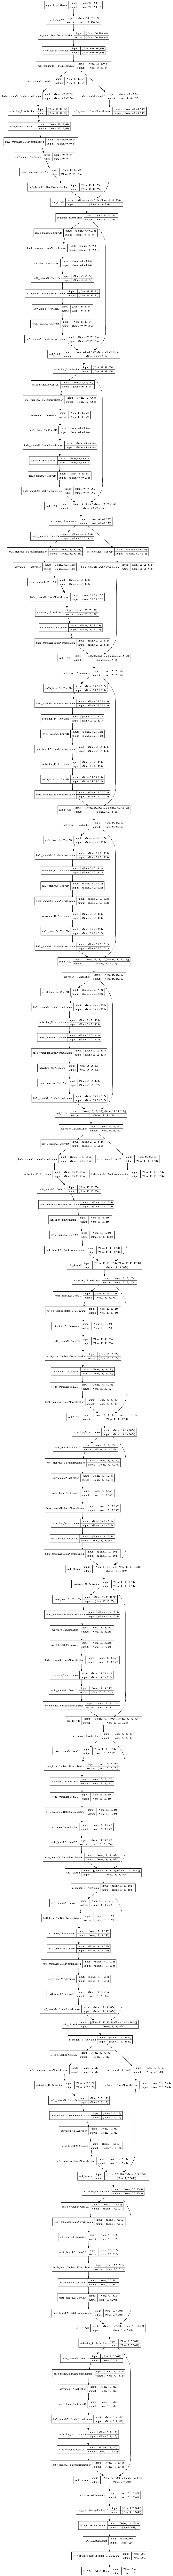

In [290]:
architecture_filepath = 'model_architecture.png'
plot_model(model, to_file=architecture_filepath, show_shapes=True)
display.Image(architecture_filepath)

## Fine-Tuning Combined Model
Since we are fine-tuning the data, we will use a Stochastic Gradient Descent optimizer with a small learning rate. This will prevent sudden weight changes that will sway the model too far from its current optima.

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=SGD(1e-4, momentum=0.5))

In [35]:
checkpoint_path = Path('Checkpoints/{}'.format(datetime.date.today()))
checkpoint_path.mkdir(exist_ok=True, parents=True)

callbacks = [
    ModelCheckpoint(str(checkpoint_path / 'VGG_fine_tune.h5'), 
                    save_best_only=True, save_weights_only=False),
    TensorBoard('Logs/{}/VGG_fine_tune_trainable_from[{}]'.format(datetime.date.today(), training_index))
]

model.fit_generator(train_generator, validation_data=dev_generator, epochs=20, callbacks=callbacks)

Epoch 1/20
469/469 [==============================] - 169s 361ms/step - loss: 1.1920 - acc: 0.7028 - val_loss: 0.6048 - val_acc: 0.8809
Epoch 2/20
469/469 [==============================] - 168s 358ms/step - loss: 0.8239 - acc: 0.8090 - val_loss: 0.5693 - val_acc: 0.8868
Epoch 3/20
469/469 [==============================] - 168s 358ms/step - loss: 0.7515 - acc: 0.8329 - val_loss: 0.5202 - val_acc: 0.9017
Epoch 4/20
469/469 [==============================] - 167s 357ms/step - loss: 0.6891 - acc: 0.8485 - val_loss: 0.5519 - val_acc: 0.8900
Epoch 5/20
469/469 [==============================] - 168s 358ms/step - loss: 0.6545 - acc: 0.8582 - val_loss: 0.5091 - val_acc: 0.9065
Epoch 6/20
469/469 [==============================] - 168s 358ms/step - loss: 0.6243 - acc: 0.8673 - val_loss: 0.4628 - val_acc: 0.9135
Epoch 7/20
469/469 [==============================] - 167s 357ms/step - loss: 0.6029 - acc: 0.8710 - val_loss: 0.4817 - val_acc: 0.9071
Epoch 8/20
469/469 [============================

Once again, the best model weights found during this training procedure is loaded.

In [39]:
# Load best model 
model = load_model(str(checkpoint_path / 'VGG_fine_tune.h5'))

## Evaluating Model Results
Finally, we are done training! Let's evaluate the Model's performance on the test dataset. 

In [40]:
model.evaluate(X_test, Y_test)

1873/1873 [==============================] - 19s 10ms/step


[0.3660082516985912, 0.9252536038441004]

## Benchmark Comparison: Multi-layer Preceptron (MLP)
As a comparison, the trained Combined Model is compared against a **Benchmark Model** (Multi-Layer Perceptron) with similar number of weights as those in Top Model. 

The inputs to this Benchmark Model are the original 28-by-28 pixel images, unlike the stacked and padded ones for the Combined Model. 

In [42]:
def create_benchmark_model_reg(input_shape, lambda_):
    X_input = Input(input_shape)
    X = Dense(256, activation='relu', kernel_regularizer=l2(lambda_))(X_input)
    X = Dense(10, activation='softmax', kernel_regularizer=l2(lambda_))(X)
    
    model = Model(X_input, X)
    
    return model

In [48]:
X_prime = data['images'].reshape(-1, 784) / 255
Y_prime = to_categorical(data['labels'])

X_train_prime, Y_train_prime, X_dev_prime, Y_dev_prime, X_test_prime, Y_test_prime = shuffle_and_split(X_prime, Y_prime)

In [49]:
benchmark_model = create_benchmark_model_reg(input_shape=(data['images'][0].size,), lambda_=1e-2)
benchmark_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [50]:
callbacks[0] = ModelCheckpoint(str(checkpoint_path / 'Benchmark_Model.h5'), save_best_only=True, save_weights_only=False)

benchmark_model.fit(X_train_prime, Y_train_prime, validation_data=(X_dev_prime, Y_dev_prime), 
          batch_size=32, epochs=200, callbacks=callbacks)

Train on 14979 samples, validate on 1872 samples
Epoch 1/200
14979/14979 [==============================] - 2s 154us/step - loss: 1.6553 - acc: 0.8573 - val_loss: 0.8298 - val_acc: 0.8467
Epoch 2/200
14979/14979 [==============================] - 2s 138us/step - loss: 0.7298 - acc: 0.8782 - val_loss: 0.6994 - val_acc: 0.8707
Epoch 3/200
14979/14979 [==============================] - 2s 141us/step - loss: 0.7075 - acc: 0.8788 - val_loss: 0.6817 - val_acc: 0.8819
Epoch 4/200
14979/14979 [==============================] - 2s 152us/step - loss: 0.7041 - acc: 0.8797 - val_loss: 0.7257 - val_acc: 0.8665
Epoch 5/200
14979/14979 [==============================] - 2s 136us/step - loss: 0.7019 - acc: 0.8786 - val_loss: 0.6951 - val_acc: 0.8702
Epoch 6/200
14979/14979 [==============================] - 2s 136us/step - loss: 0.6917 - acc: 0.8818 - val_loss: 0.7535 - val_acc: 0.8408
Epoch 7/200
14979/14979 [==============================] - 2s 135us/step - loss: 0.6885 - acc: 0.8818 - val_loss: 0.6

14979/14979 [==============================] - 2s 138us/step - loss: 0.6266 - acc: 0.8945 - val_loss: 0.6155 - val_acc: 0.8910
Epoch 118/200
14979/14979 [==============================] - 2s 138us/step - loss: 0.6304 - acc: 0.8930 - val_loss: 0.6291 - val_acc: 0.8980
Epoch 119/200
14979/14979 [==============================] - 2s 137us/step - loss: 0.6283 - acc: 0.8940 - val_loss: 0.6308 - val_acc: 0.8916
Epoch 120/200
14979/14979 [==============================] - 2s 136us/step - loss: 0.6270 - acc: 0.8938 - val_loss: 0.6305 - val_acc: 0.8910
Epoch 121/200
14979/14979 [==============================] - 2s 135us/step - loss: 0.6288 - acc: 0.8926 - val_loss: 0.6105 - val_acc: 0.8980
Epoch 122/200
14979/14979 [==============================] - 2s 136us/step - loss: 0.6252 - acc: 0.8943 - val_loss: 0.6196 - val_acc: 0.8884
Epoch 123/200
14979/14979 [==============================] - 2s 136us/step - loss: 0.6272 - acc: 0.8933 - val_loss: 0.6195 - val_acc: 0.8942
Epoch 124/200
14979/14979 [

In [53]:
benchmark_model = load_model(str(checkpoint_path/ 'Benchmark_Model.h5'))
benchmark_model.evaluate(X_test_prime, Y_test_prime)

1873/1873 [==============================] - 0s 121us/step


[0.6327935529149794, 0.8884143086594818]

## Conclusion
Using transfer learning, we managed to utilise the advanced feature extraction capabilities of a VGG16 model for our custom image classification task (in this case, on the *notMNIST* dataset). 

The Combined Model that utilises transfer learning has a test accuracy of 92.5%, while the Benchmark MLP Model scores a test accuracy of only 88.8%. Due to time constraints, this former was only trained for 20 epochs. Its accuracy could certainly be improved further with more training, as shown by increasing validation accuracy in the TensorBoard screenshot below.

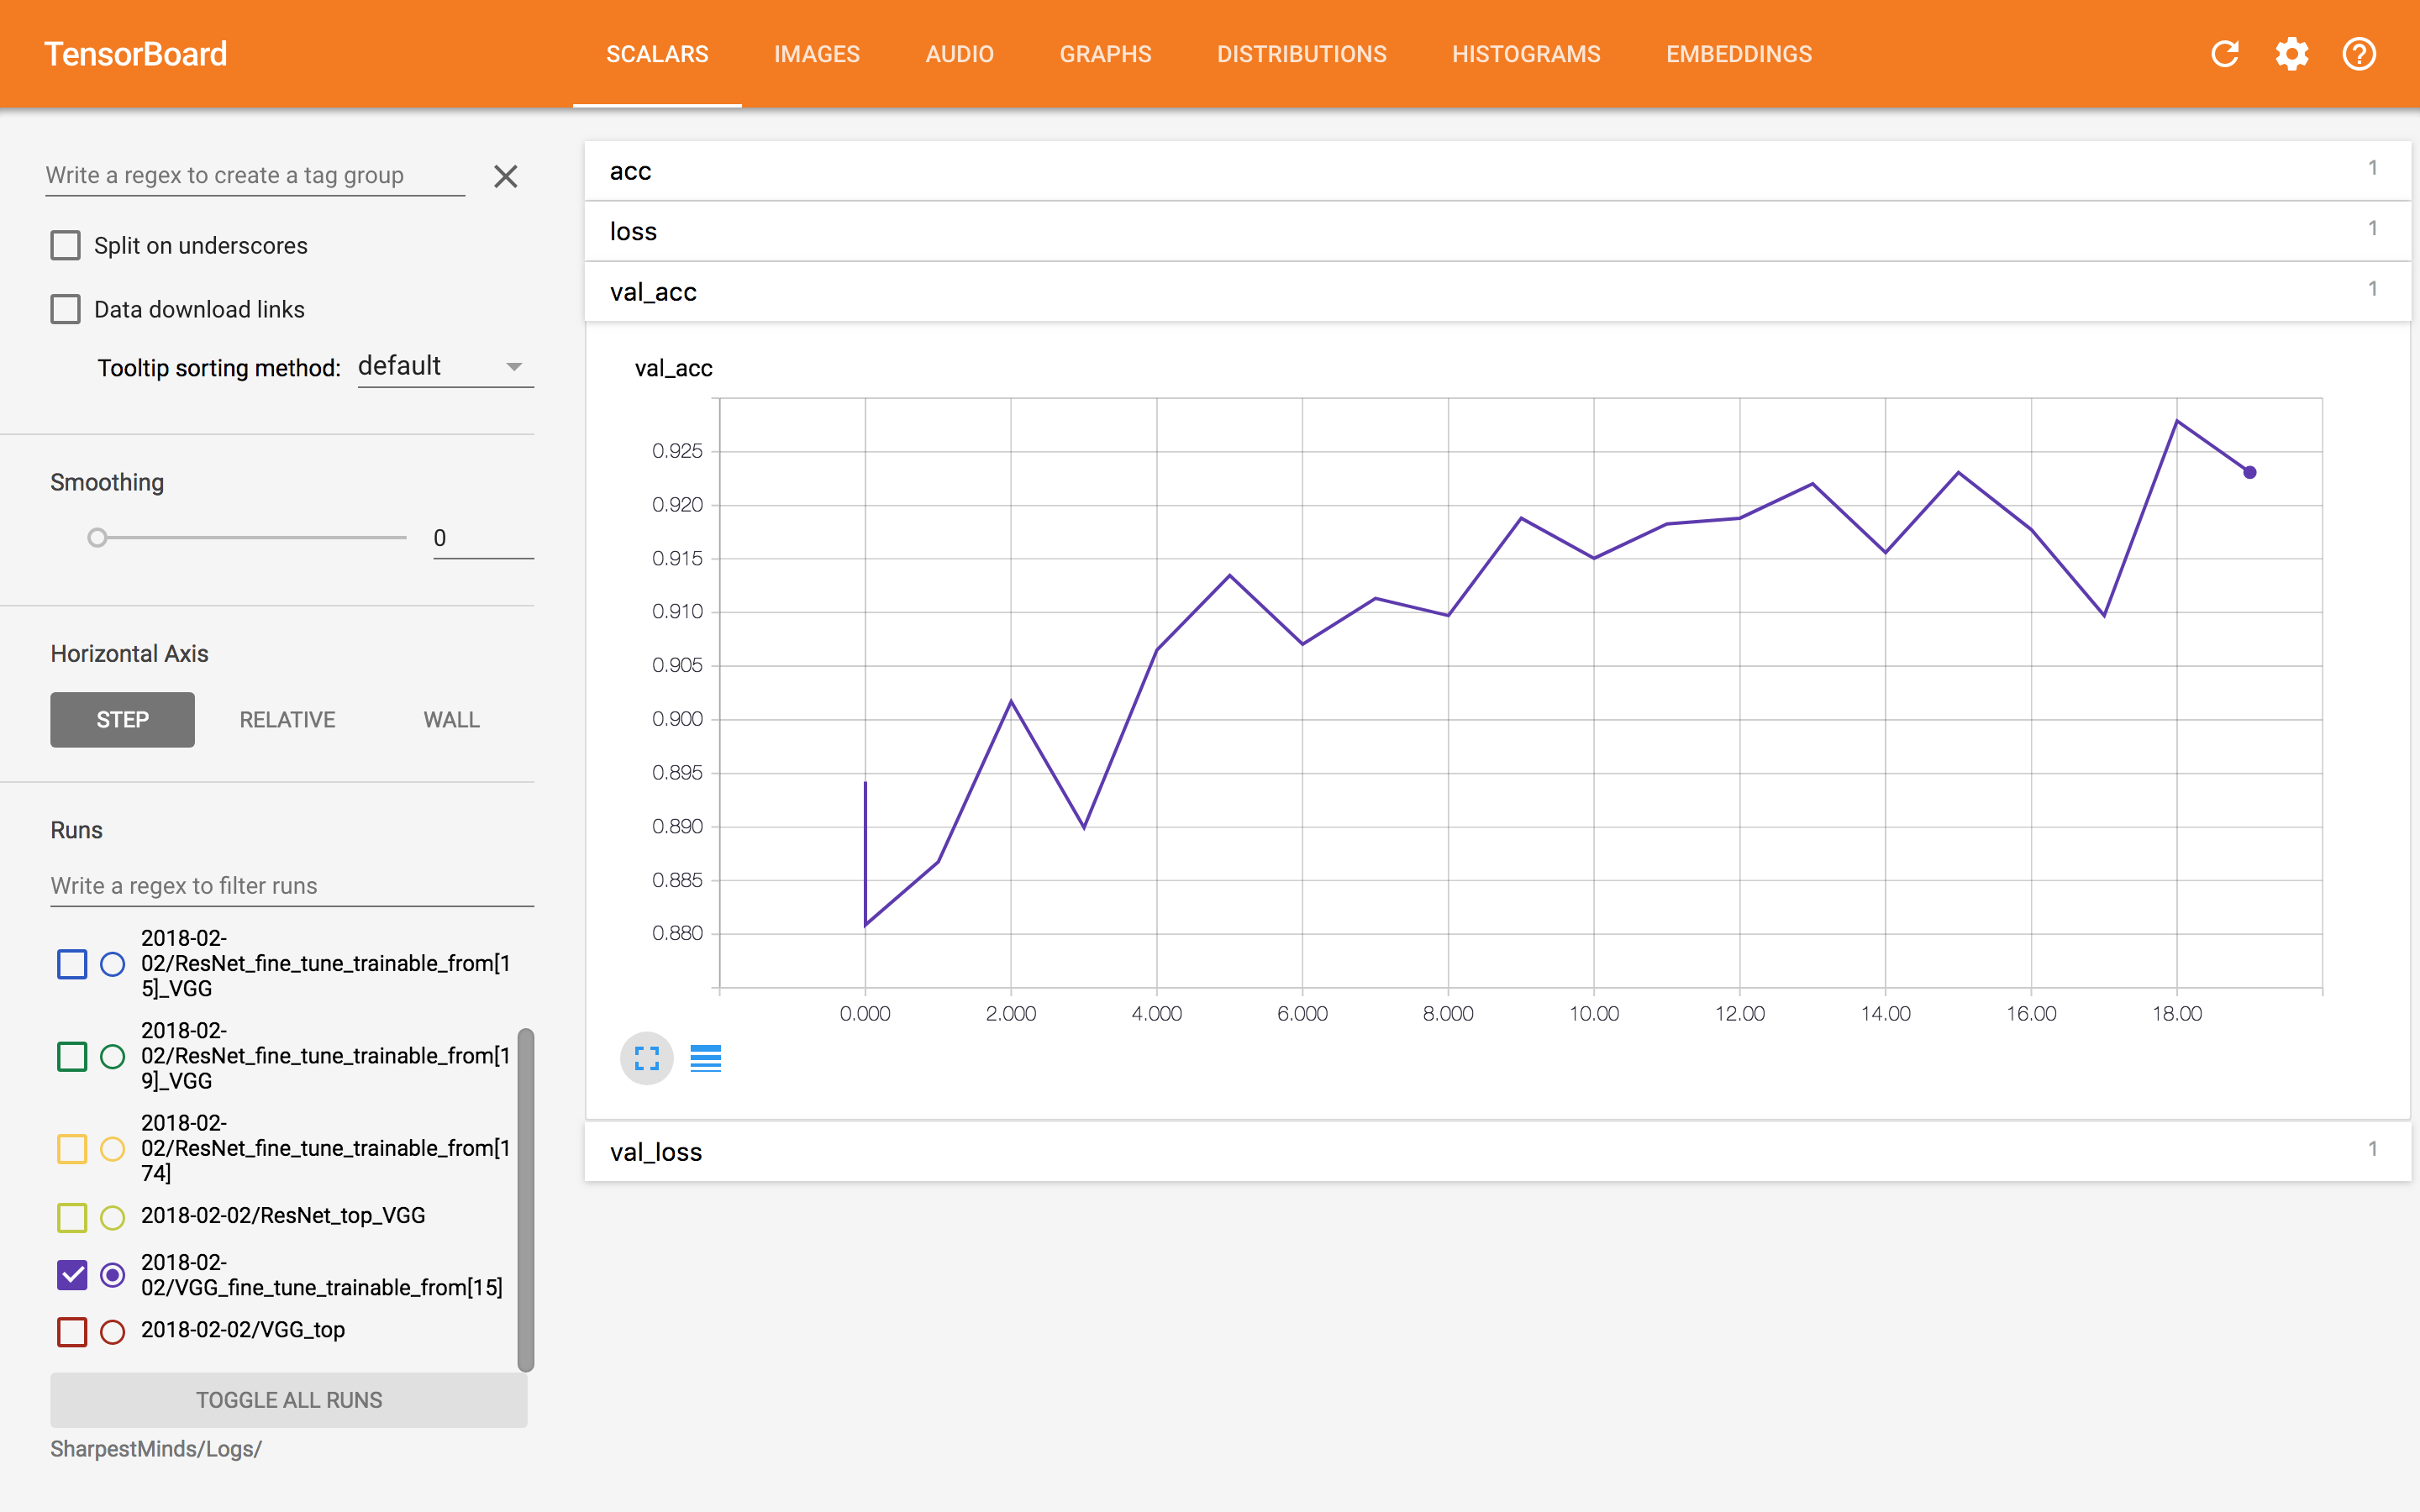

In [41]:
display.Image('Valid Acc.png')